# Movies Dataset EDA & Simple Recommendation Models

In [1]:
# Data Retrieved from: https://grouplens.org/datasets/movielens/
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()
# alt.data_transformers.enable('csv')
import jupyter
import vega
import notebook

# import plotly
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
from datetime import datetime as dt

from ast import literal_eval

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

# plotly.tools.set_credentials_file(username='zacbburns', api_key='SiQa89r3SYnwM4hmTluX')
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)

## Simple Popularity Based Recommender

In [2]:
df = pd.read_csv('./ml-latest-small/movies_metadata.csv').drop(columns=['belongs_to_collection',
                                                                        'poster_path', 'homepage',
                                                                        'production_companies',
                                                                        'production_countries',
                                                                        'revenue',
                                                                        'runtime',
                                                                        'spoken_languages'])
df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,status,tagline,title,video,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,Released,NaN,Toy Story,False,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,1995-02-10,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
# Need to clean up the genres column here. Let's build a function to extract the genres each 
# film belongs to and place them into a list
# The lists were stored as a string representation of a list of dictionaries so we need to use the literal_eval 
# function to correct this

df['genres'] = df['genres'].fillna('[]').apply(lambda x: literal_eval(x)).apply(lambda x: [elem['name'] for elem in x])
df.head()


,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,status,tagline,title,video,vote_average,vote_count
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,Released,NaN,Toy Story,False,7.7,5415.0
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,0,[Comedy],11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,1995-02-10,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
isinstance(df['genres'].iloc[0], list)

True

I use the TMDB Ratings to come up with our Top Movies Chart. I will use IMDB's weighted rating formula to construct my chart. Mathematically, it is represented as follows:

$$Weighted Rating  (WR) = (\frac{v}{v+m}R) + (\frac{m}{v+m}C)$$

where,

v is the number of votes for the movie <br>
m is the minimum votes required to be listed in the chart <br>
R is the average rating of the movie <br>
C is the mean vote across the whole report <br>

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list

In [4]:
vote_counts = df[df['vote_count'].notnull()]['vote_count'].quantile(0.90)
vote_counts

160.0

#### So, for a movie to qualify to be in our list, it must have atleast 160 votes

Now, let's determine a minimum average vote for any single movie to qualify to be in the list. Let's set
the cut off point to be an average rating of 6

In [5]:
vote_average = df[df['vote_average'].notnull()]['vote_average'].mean()
vote_average

5.618207215133889

Lets filter out the movies that don't meet the above conditions and only keep the columns we will need

In [7]:
vote_count_pred = df['vote_count'] >= 160
vote_avg_pred = df['vote_average'] >= 6

qualified_df = df[(vote_count_pred) & (vote_avg_pred)]
qualified_df.shape

(3324, 16)

In [8]:
qualified_df['release_date'] = qualified_df['release_date'].map(lambda x: str(x).split('-')[0] if 
                                                                x != np.nan else np.nan)

In [9]:
def weighted_rating(df):
    v = df['vote_count']
    r = df['vote_average']

    return (v/(v+vote_counts) *r) + (vote_counts/(v+vote_counts) *vote_average)

qualified_df['weighted_rating'] = qualified_df.apply(weighted_rating,axis=1)

Using this weighted rating, now we can see what the top rated movies are

In [10]:
qualified_df.sort_values('weighted_rating',ascending=False).head(10)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,status,tagline,title,video,vote_average,vote_count,weighted_rating
314,False,25000000,"[Drama, Crime]",278,tt0111161,en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,51.6454,1994,Released,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,False,8.5,8358.0,8.445869
834,False,6000000,"[Drama, Crime]",238,tt0068646,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",41.1093,1972,Released,An offer you can't refuse.,The Godfather,False,8.5,6024.0,8.425439
10309,False,13200000,"[Comedy, Drama, Romance]",19404,tt0112870,hi,Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...",34.457,1995,Released,Come... Fall In Love,Dilwale Dulhania Le Jayenge,False,9.1,661.0,8.421453
12481,False,185000000,"[Drama, Action, Crime, Thriller]",155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167,2008,Released,Why So Serious?,The Dark Knight,False,8.3,12269.0,8.265477
2843,False,63000000,[Drama],550,tt0137523,en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,63.8696,1999,Released,Mischief. Mayhem. Soap.,Fight Club,False,8.3,9678.0,8.256385
292,False,8000000,"[Thriller, Crime]",680,tt0110912,en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",140.95,1994,Released,Just because you are a character doesn't mean ...,Pulp Fiction,False,8.3,8670.0,8.251406
522,False,22000000,"[Drama, History, War]",424,tt0108052,en,Schindler's List,The true story of how businessman Oskar Schind...,41.7251,1993,Released,"Whoever saves one life, saves the world entire.",Schindler's List,False,8.3,4436.0,8.206639
23673,False,3300000,[Drama],244786,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.3,2014,Released,The road to greatness can take you to the edge.,Whiplash,False,8.3,4376.0,8.205404
5481,False,15000000,"[Fantasy, Adventure, Animation, Family]",129,tt0245429,ja,千と千尋の神隠し,A ten year old girl who wanders away from her ...,41.0489,2001,Released,The tunnel led Chihiro to a mysterious town...,Spirited Away,False,8.3,3968.0,8.196055
2211,False,20000000,"[Comedy, Drama]",637,tt0118799,it,La vita è bella,A touching story of an Italian book seller of ...,39.395,1997,Released,"An unforgettable fable that proves love, famil...",Life Is Beautiful,False,8.3,3643.0,8.187171


### let's build a function that will return the top 20 movies for a specified genre (Based on the weighted rating)

Since movies fall into more than one genre, we will need to extract each genre and expand the dataframe to include
these so we can filter the DF by genre. 

In [11]:
# https://stackoverflow.com/questions/42012152/unstack-a-pandas-column-containing-lists-into-multiple-rows
# basically, we want to take each genre in the list of genres, and make it its own row. We need this because if 
# we want to do any aggregation on genres, it will be helpful to have them split into seperate rows

s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(s)
gen_df.head()

,adult,budget,id,imdb_id,original_language,original_title,overview,popularity,release_date,status,tagline,title,video,vote_average,vote_count,genre
0,False,30000000,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,Released,NaN,Toy Story,False,7.7,5415.0,Animation
0,False,30000000,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,Released,NaN,Toy Story,False,7.7,5415.0,Comedy
0,False,30000000,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,Released,NaN,Toy Story,False,7.7,5415.0,Family
1,False,65000000,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Adventure
1,False,65000000,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Fantasy


In the plot below, we can see that there are alot more poplular than the others. Most notably, we see that 
Adventure, Action, Comedy, Fantasy and Science Fiction seem to be the most popular genres

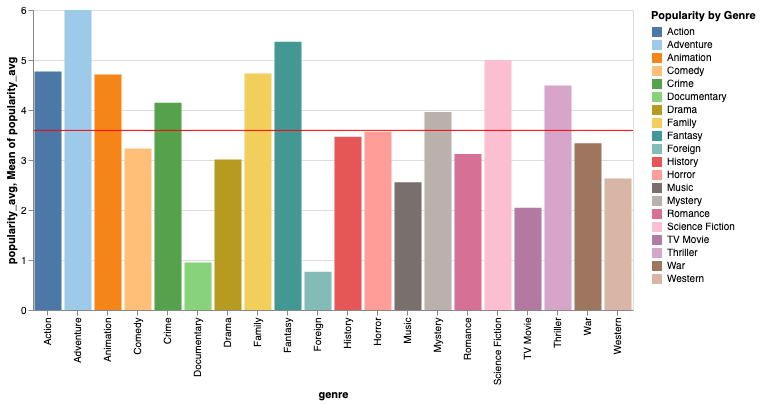

In [38]:
# def plot_against_genre(df, col)
gen_df['popularity'] = pd.to_numeric(gen_df['popularity'], errors='coerce')
genre_pop_df = gen_df.groupby('genre').agg(
                                        count=('genre','count'), 
                                        popularity_avg=('popularity', np.mean),
                                        voting_avg=('vote_average', np.mean))\
                                      .dropna()\
                                      .sort_values('popularity_avg', ascending=False)\
                                      .reset_index()

bar = alt.Chart(genre_pop_df).mark_bar().encode(
    x='genre:O',
    y='popularity_avg:Q',
    color=alt.Color('genre', legend=alt.Legend(title='Popularity by Genre'), scale=alt.Scale(scheme='tableau20'))
)
rule = alt.Chart(genre_pop_df).mark_rule(color='red').encode(
    y='mean(popularity_avg):Q'
)


(bar + rule).properties(width=600)

We can see that there really doesn't seem to be any significant difference between genres when looking at the average rating

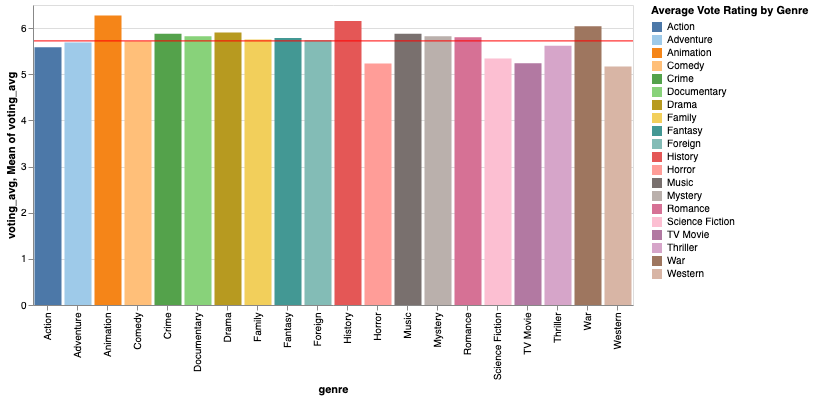

In [29]:
bar2 = alt.Chart(genre_pop_df).mark_bar().encode(
    x='genre:O',
    y='voting_avg:Q',
    color=alt.Color('genre', legend=alt.Legend(title='Average Vote Rating by Genre'), scale=alt.Scale(scheme='tableau20'))
)
rule2 = alt.Chart(genre_pop_df).mark_rule(color='red').encode(
    y='mean(voting_avg):Q'
)

(bar2 + rule2).properties(width=600)

In [39]:
gen_df.head()

,adult,budget,id,imdb_id,original_language,original_title,overview,popularity,release_date,status,tagline,title,video,vote_average,vote_count,genre
0,False,30000000,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,Released,NaN,Toy Story,False,7.7,5415.0,Animation
0,False,30000000,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,Released,NaN,Toy Story,False,7.7,5415.0,Comedy
0,False,30000000,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,Released,NaN,Toy Story,False,7.7,5415.0,Family
1,False,65000000,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Adventure
1,False,65000000,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Fantasy


In [40]:
vote_average = df[df['vote_average'].notnull()]['vote_average'].mean()
vote_counts = df[df['vote_count'].notnull()]['vote_count'].quantile(0.90)

def top_movies_by_genre(df, genre, len_list=20, percentile=0.90):
    
    filt_df = df[df['genre'] == genre]
    vote_counts = filt_df[filt_df['vote_count'].notnull()]['vote_count'].quantile(percentile)
    vote_avg = filt_df[filt_df['vote_average'].notnull()]['vote_count'].mean()
    
    qualified_df = filt_df[(filt_df['vote_count'] >= vote_counts) &
                           (filt_df['vote_average'].notnull()) &
                           (filt_df['vote_count'].notnull())]

    qualified_df['weighted_rating'] = qualified_df.apply(
        lambda x: (x['vote_count']/(x['vote_count']+ vote_counts) * x['vote_average']) + 
                  (vote_counts/(vote_counts+x['vote_count']) * vote_average), axis=1)
    
    return qualified_df.sort_values('weighted_rating', ascending=False).head(len_list)


top_movies = top_movies_by_genre(gen_df, 'Action')
top_movies

,adult,budget,id,imdb_id,original_language,original_title,overview,popularity,release_date,status,tagline,title,video,vote_average,vote_count,genre,weighted_rating
12481,False,185000000,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167259,2008-07-16,Released,Why So Serious?,The Dark Knight,False,8.3,12269.0,Action,8.196725
15480,False,160000000,27205,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",29.108149,2010-07-14,Released,Your mind is the scene of the crime.,Inception,False,8.1,14075.0,Action,8.016276
1154,False,18000000,1891,tt0080684,en,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...",19.470959,1980-05-17,Released,The Adventure Continues...,The Empire Strikes Back,False,8.2,5998.0,Action,8.004498
7000,False,94000000,122,tt0167260,en,The Lord of the Rings: The Return of the King,Aragorn is revealed as the heir to the ancient...,29.324358,2003-12-01,Released,The eye of the enemy is moving.,The Lord of the Rings: The Return of the King,False,8.1,8226.0,Action,7.960101
256,False,11000000,11,tt0076759,en,Star Wars,Princess Leia is captured and held hostage by ...,42.149697,1977-05-25,Released,"A long time ago in a galaxy far, far away...",Star Wars,False,8.1,6778.0,Action,7.932235
4863,False,93000000,120,tt0120737,en,The Lord of the Rings: The Fellowship of the Ring,"Young hobbit Frodo Baggins, after inheriting a...",32.070725,2001-12-18,Released,One ring to rule them all,The Lord of the Rings: The Fellowship of the Ring,False,8.0,8892.0,Action,7.875268
5814,False,79000000,121,tt0167261,en,The Lord of the Rings: The Two Towers,Frodo and Sam are trekking to Mordor to destro...,29.423537,2002-12-18,Released,A New Power Is Rising.,The Lord of the Rings: The Two Towers,False,8.0,7641.0,Action,7.856080
23753,False,170000000,118340,tt2015381,en,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",53.291601,2014-07-30,Released,All heroes start somewhere.,Guardians of the Galaxy,False,7.9,10014.0,Action,7.793267
2458,False,63000000,603,tt0133093,en,The Matrix,"Set in the 22nd century, The Matrix tells the ...",33.366332,1999-03-30,Released,Welcome to the Real World.,The Matrix,False,7.9,9079.0,Action,7.782839
13605,False,70000000,16869,tt0361748,en,Inglourious Basterds,"In Nazi-occupied France during World War II, a...",16.895640,2009-08-18,Released,Once upon a time in Nazi occupied France...,Inglourious Basterds,False,7.9,6598.0,Action,7.741838


According to our metrics, we can see that the top action movie is The Dark Knight, followed by: Inception and the Empire Strikes Back

## Content Based Recommendation Model

Now we are going to build a Content Based recommendation model. The popularity based recommendation model has some severe limitations. Since it does not give personalized recommendations, alot of the suggestions on our Top 20 chart would may not be suitable for a particular user. For someone who likes action or romance movies only, even breaking down by genre may not provide suitable enough recommendations

In order to do this, we are going to build a Content Based Recommendation model which will calculate the similarities between movies based on certain metrics and will recommend movies similar to movies the user has previously liked. These metrics for computing similarity will be based on:

1. Movie Overviews and Taglines
2. Movie cast, crew, Keywords and Genre




In [41]:
links = pd.read_csv('./ml-latest-small/links.csv')
links = links[links['tmdbId'].notnull()]['tmdbId']

In [42]:
links.head()

0      862.0
1     8844.0
2    15602.0
3    31357.0
4    11862.0
Name: tmdbId, dtype: float64

In [43]:
# Bad rows here, will need to drop these
df[df['id']=='1997-08-20'].head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
clean_df = df.drop([19730, 29503, 35587])
clean_df['id'] = clean_df['id'].astype('int')


In [45]:
# Now let's filter only moves that are contained in the links.csv file
filt_df = clean_df[clean_df['id'].isin(links)]
filt_df.shape

(9553, 16)

In [46]:
filt_df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,status,tagline,title,video,vote_average,vote_count
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,Released,NaN,Toy Story,False,7.7,5415.0
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,0,[Comedy],11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,1995-02-10,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


Since we are going to use Movie Overviews and Taglines, we need to do some preprocessing before we can use these features

In [47]:
filt_df['tagline'] = filt_df['tagline'].fillna('')
filt_df['description'] = filt_df['overview'] + filt_df['tagline']
filt_df['description'] = filt_df['description'].fillna('')

In [48]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(filt_df['description'])
tfidf_matrix.shape

(9553, 276438)

#### Cosine Similarity

I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

$cosine(x,y)= \frac{x.y^⊺}{||x||.||y||}$

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [49]:
cos_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cos_sim[0]

array([1.        , 0.00680615, 0.        , ..., 0.        , 0.        ,
       0.        ])

Now we have a cosine similarity matrix between all the movies in our dataset. All we have to do now is to create
a function which will return a list of the top N movies based on the cosine similarity score

In [50]:
filt_df = filt_df.reset_index()
movies = filt_df['title']
indices = pd.Series(movies.index, index=movies)

In [51]:
def get_movie_recommendations(title, len_of_list=10):
    idx = indices[title]
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)
    top_n_movies = sim_scores[0:len_of_list+1]
    movie_indices = [i[0] for i in top_n_movies]
    # Need to shift the index by 1 since the first movie returned is always the title placed in the function
    # Since they are the same movie, they have a perfect correlation of +1.0
    return movies.iloc[movie_indices[1:]]

print(get_movie_recommendations('Toy Story'))

2352               Toy Story 2
7336               Toy Story 3
5958    The 40 Year Old Virgin
2389           Man on the Moon
6405              Factory Girl
4452    What's Up, Tiger Lily?
839      Rebel Without a Cause
6327    For Your Consideration
4760          Rivers and Tides
9172      Welcome to Happiness
Name: title, dtype: object


In [52]:
get_movie_recommendations('The Dark Knight')

7745                      The Dark Knight Rises
126                              Batman Forever
1058                             Batman Returns
7361                 Batman: Under the Red Hood
509                                      Batman
8056    Batman: The Dark Knight Returns, Part 2
9412                      The Lego Batman Movie
7710                           Batman: Year One
5620         Batman Beyond: Return of the Joker
2523                                        JFK
Name: title, dtype: object

In [53]:
get_movie_recommendations('Inception')

135                                Crumb
6166                         Renaissance
8598                  Closer to the Moon
627                            Lone Star
1604                               House
4492                    The Pink Panther
312                                 Cobb
2646    What Ever Happened to Baby Jane?
8461                             The Den
926          Once Upon a Time in America
Name: title, dtype: object

This recommender only uses the movie overview and taglines to provide recommendations, which isn't very helpful. We want to be able to provide more sophiscated suggestions using genre, cast and crew as well...

In [54]:
credits = pd.read_csv('./ml-latest-small/credits.csv')
kwds = pd.read_csv('./ml-latest-small/keywords.csv')

credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [55]:
credits['id'] = credits['id'].astype('int')
kwds['id'] = kwds['id'].astype('int')
clean_df.shape

(45463, 16)

In [56]:
merged_df = clean_df.merge(credits, on='id').merge(kwds, on='id')
merged_df.shape

(46628, 19)

In [57]:
cast_crew_df = merged_df[merged_df['id'].isin(links)]
cast_crew_df.shape

(9657, 19)

In [58]:
cast_crew_df['cast'] = cast_crew_df['cast'].apply(literal_eval)
cast_crew_df['crew'] = cast_crew_df['crew'].apply(literal_eval)
cast_crew_df['keywords'] = cast_crew_df['keywords'].apply(literal_eval)

In [59]:
cast_crew_df['cast_size'] = cast_crew_df['cast'].apply(lambda x: len(x))
cast_crew_df['crew_size'] = cast_crew_df['crew'].apply(lambda x: len(x))

cast_crew_df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,...,tagline,title,video,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,...,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10
4,False,0,[Comedy],11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,1995-02-10,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7


In [32]:
cast_crew_df['director'] = cast_crew_df['crew'].apply(lambda x: [i['name'] for i in x if i['job'] == 'Director'])
# Removing this because there can be multiple directors for a single movie
# cast_crew_df['director'] = cast_crew_df['director'].apply(lambda x: ', '.join(map(str,x)))
cast_crew_df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,...,title,video,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size,director
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,...,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,[John Lasseter]
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,...,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16,[Joe Johnston]
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4,[Howard Deutch]
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10,[Forest Whitaker]
4,False,0,[Comedy],11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,1995-02-10,...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7,[Charles Shyer]


In [33]:
# Since each movie can have many many cast members, we are going to only take the first 5 (which should include the main actors)
cast_crew_df['cast'] = cast_crew_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
cast_crew_df['top_5_cast'] = cast_crew_df['cast'].apply(lambda x: x[:6] if len(x) >= 6 else x)
cast_crew_df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,...,video,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size,director,top_5_cast
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,...,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,[John Lasseter],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,...,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16,[Joe Johnston],"[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,...,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4,[Howard Deutch],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,...,False,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10,[Forest Whitaker],"[Whitney Houston, Angela Bassett, Loretta Devi..."
4,False,0,[Comedy],11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,1995-02-10,...,False,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7,[Charles Shyer],"[Steve Martin, Diane Keaton, Martin Short, Kim..."


In [34]:
# Now, let's deal with the keywords
cast_crew_df['keywords'] = cast_crew_df['keywords'].apply(lambda x: 
                                                          [i['name'] for i in x] if isinstance(x, list) else [])
cast_crew_df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,...,video,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size,director,top_5_cast
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,...,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,[John Lasseter],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,...,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,[Joe Johnston],"[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,...,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,[Howard Deutch],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,...,False,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,[Forest Whitaker],"[Whitney Houston, Angela Bassett, Loretta Devi..."
4,False,0,[Comedy],11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,1995-02-10,...,False,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,[Charles Shyer],"[Steve Martin, Diane Keaton, Martin Short, Kim..."


In [35]:
cast_crew_df['cast'] = cast_crew_df['cast'].apply(lambda x: [str.lower(i.replace(' ', '')) for i in x])

cast_crew_df['director'] = cast_crew_df['director'].apply(lambda x: [str.lower(i.replace(' ', '')) for i in x])

In [36]:
keyword_freq_counts = cast_crew_df.apply(lambda x: pd.Series(cast_crew_df['keywords']),axis=1)\
                                                   .stack()\
                                                   .reset_index(level=1, drop=True)
keyword_freq_counts.name = 'keywords'

In [ ]:
kwd_freq = keyword_freq_counts[keyword_freq_counts.str.len() > 1].value_counts()
kwd_freq.shape

In [38]:
# kwd_freq = keyword_freq_counts.value_counts()
# kwd_freq = kwd_freq[kwd_freq > 1]
# kwd_freq[:10]

In [39]:
stemmer = SnowballStemmer(language='english')
stemmer.stem('Dogs')

'dog'

In [40]:
# freq = keyword_freq_counts.value_counts()
# freq = freq[freq > 1]

# def filter_keywords(x):
#     words = []
#     for i in x:
#         if i in kwd_freq:
#             words.append(i)
#     return words

In [42]:
words = []
# cast_crew_df['keywords'] = cast_crew_df['keywords'].apply(lambda x: words.append(x) if )
cast_crew_df['keywords'] = cast_crew_df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
cast_crew_df['keywords'] = cast_crew_df['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [43]:
cast_crew_df['feature_vec'] = cast_crew_df['keywords'] +\
                              cast_crew_df['top_5_cast'] +\
                              cast_crew_df['director'] +\
                              cast_crew_df['genres']
            
cast_crew_df['feature_vec'] = cast_crew_df['feature_vec'].apply(lambda x: ' '.join(x))
cast_crew_df.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,release_date,...,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size,director,top_5_cast,feature_vec
0,False,30000000,"[Animation, Comedy, Family]",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,...,7.7,5415.0,"[tomhanks, timallen, donrickles, jimvarney, wa...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,[johnlasseter],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",jealousi toy boy friendship friend rivalri boy...
1,False,65000000,"[Adventure, Fantasy, Family]",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,...,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst, br...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,[joejohnston],"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",boardgam disappear basedonchildren'sbook newho...
2,False,0,"[Romance, Comedy]",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,...,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret, sophi...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting, oldmen]",7,4,[howarddeutch],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",fish bestfriend duringcreditssting oldmen Walt...
3,False,16000000,"[Comedy, Drama, Romance]",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,1995-12-22,...,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine,...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",10,10,[forestwhitaker],"[Whitney Houston, Angela Bassett, Loretta Devi...",basedonnovel interracialrelationship singlemot...
4,False,0,[Comedy],11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,1995-02-10,...,5.7,173.0,"[stevemartin, dianekeaton, martinshort, kimber...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...",12,7,[charlesshyer],"[Steve Martin, Diane Keaton, Martin Short, Kim...",babi midlifecrisi confid age daughter motherda...


In [44]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(cast_crew_df['feature_vec'])

In [45]:
cos_sim = cosine_similarity(count_matrix, count_matrix)

In [46]:
cast_crew_df = cast_crew_df.reset_index()
titles = cast_crew_df['title']
indices = pd.Series(cast_crew_df.index, index=titles)

In [47]:
get_movie_recommendations('The Dark Knight').head(10)

7811    The Prince and the Pauper
5963                      Valiant
5661                        11:14
1072              Raising Arizona
6375                    Dead Meat
7427                 Heartbreaker
9284                 Ghostbusters
9285         Central Intelligence
1185                      Contact
7332            Letters to Juliet
Name: title, dtype: object

In [48]:
get_movie_recommendations('Inception').head(10)

7135    Assassination of a High School President
8021                      Half a Loaf of Kung Fu
7764                               The Iron Lady
3899                       Nosferatu the Vampyre
5383                              Blade: Trinity
7057                                       Brüno
7271                          Our Family Wedding
8007                       Indie Game: The Movie
8718                                    The Loft
5701               Bobby Jones: Stroke of Genius
Name: title, dtype: object

In [49]:
get_movie_recommendations('The Shawshank Redemption').head(10)

5941                                       Broken Flowers
3555                                      Better Than Sex
4339                                             Breakin'
5195                           The Picture of Dorian Gray
5670                                   The Green Butchers
7937                                           ParaNorman
5218                                         The Notebook
3409                                     Bread and Tulips
1713    Love Is the Devil: Study for a Portrait of Fra...
3318                                        The Dead Pool
Name: title, dtype: object

In [50]:
cast_crew_df['year'] = cast_crew_df['release_date'].map(lambda x: str(x).split('-')[0] if 
                                                        x != np.nan else np.nan)

Popularity and Ratings
One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. It is true that Batman and Robin has a lot of similar characters as compared to The Dark Knight but it was a terrible movie that shouldn't be recommended to anyone.

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

I will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of  m , we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [51]:
def improved_recommendations(title, len_of_list=20, percentile=0.50):
    
    idx = indices[title]
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:len_of_list+1]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = cast_crew_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    
    mean_vote_score = vote_averages.mean()
    min_votes_req = vote_counts.quantile(percentile)
    
    qualified = movies[(movies['vote_average'] >= mean_vote_score) &
                       (movies['vote_count'] >= min_votes_req) &
                       (movies['vote_average'].notnull()) &
                       (movies['vote_count'].notnull())]
    
    qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)
    return qualified.sort_values('weighted_rating', ascending=False).head(len_of_list)

improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,weighted_rating
6375,The Prestige,4510.0,8.0,2006,7.918397
7811,The Dark Knight Rises,9263.0,7.6,2012,7.566350
5963,Batman Begins,7511.0,7.5,2005,7.460750
509,Batman,2145.0,7.0,1989,6.904084
1072,Batman Returns,1706.0,6.6,1992,6.515816
9423,Batman: The Killing Joke,485.0,6.2,2016,6.055679


In [53]:
cast_crew_df[(cast_crew_df['title'] == 'Interstellar')]

,index,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,...,vote_count,cast,crew,keywords,cast_size,crew_size,director,top_5_cast,feature_vec,year
8414,23076,False,165000000,"[Adventure, Drama, Science Fiction]",157336,tt0816692,en,Interstellar,Interstellar chronicles the adventures of a gr...,32.2135,...,11187.0,"[matthewmcconaughey, jessicachastain, annehath...","[{'credit_id': '54cba75b925141678e014d1a', 'de...","[savingtheworld, artificialintellig, fatherson...",36,120,[christophernolan],"[Matthew McConaughey, Jessica Chastain, Anne H...",savingtheworld artificialintellig fathersonrel...,2014
